In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing

In [12]:
#import data
df = pd.read_csv('/Users/lennardreihs/EPFL/Master/MA2/AI4chem/ai4chem/docs/data/cycpeptdb_clean.csv', header = 0)
n = len(df)
tpsa_values = np.array(df['TPSA'])
logp_values = np.array(df['Permeability'])
mw_values = np.array(df['MolWt'])
sequence_logp_string = np.array(df['Sequence_LogP'].tolist())
sequence_logp = [ast.literal_eval(s) for s in sequence_logp_string]
fr_values_df = df[[col for col in df.columns if col.startswith('fr_')]]
fr_values = np.zeros((n, len(fr_values_df.iloc[1,:])))
for i in range(n):
    fr_values[i] = np.array(fr_values_df.iloc[i,:].values.tolist())

[(-3.0, -10.0),
 (-3.0, -10.0),
 Text(0.5, 0, '$\\log{P}_{\\mathrm{exp}}$'),
 Text(0, 0.5, '$\\log{P}_{\\mathrm{pred}}$')]

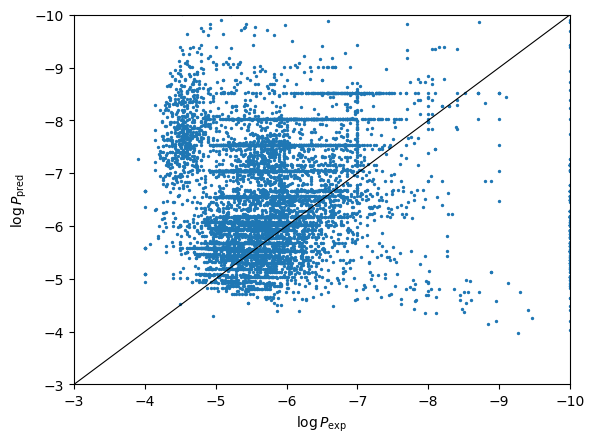

In [13]:
logp_pred = 0.008 * mw_values - 0.043 * tpsa_values - 5.165 #empirical relation from Barret (2018)
error = np.abs(logp_values - logp_pred)

cutoff = 2
counter = 0

for error_i in error:
    if error_i < cutoff:
        counter += 1

# fig, ax = plt.subplots()
# ax.scatter(np.linspace(0, n - 1, n), error, s = 2, label = r'$\log{P}_{\mathrm{pred}} - \log{P}_{\mathrm{exp}}$')
# ax.plot((0,n), (cutoff, cutoff), c = 'r', label = 'cutoff')
# ax.set(xlabel = 'peptide index', ylabel = 'absolute error')
# ax.text(3600, 10, f'{counter} peptides ({int(counter/n*100)} %) within cutoff')
# plt.legend()

fig, ax = plt.subplots()
ax.scatter(logp_values, logp_pred, s = 2)
ax.plot((0,-30), (0,-30), c = 'k', lw = .8)
ax.set(xlim = (-3,-10), ylim = (-3,-10), xlabel = r'$\log{P}_{\mathrm{exp}}$', ylabel = r'$\log{P}_{\mathrm{pred}}$')
# plt.text(-1, -28, r'$\log{P}_{\mathrm{pred}} = 0.008\cdot MW - 0.043\cdot PSA-5.165$')


In [15]:
def linear_regression(X, y,lamb=0.1):
    return np.linalg.inv(X.T.dot(X)+lamb*np.eye(X.shape[1])).dot(X.T).dot(y)

In [24]:
# Regression model 1 
# - input: MW & TPSA

# preprocessing

X1_tot = [[mw_values[i], tpsa_values[i]] for i in range(n)]
y1_tot = logp_values

X1_t, X1_test, y1_t, y1_test = train_test_split(X1_tot, y1_tot, test_size=0.2)
X1_train, X1_validation, y1_train, y1_validation = train_test_split(X1_t, y1_t, test_size=0.25)

scaler_X1 = preprocessing.StandardScaler().fit(X1_train)
scaler_y1 = preprocessing.StandardScaler().fit(y1_train.reshape(-1,1))

X1_test=scaler_X1.transform(X1_test)
X1_train=scaler_X1.transform(X1_train)
X1_validation=scaler_X1.transform(X1_validation)

# regression

w1 = linear_re